In [224]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split


%matplotlib inline

In [292]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT =0
VOCAB_SIZE =2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA_FILE = 'SpamData/02_Training/training-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [4]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
is_body = False
lines=[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body = True
        print(line)

stream.close()
email_body = '\n'.join(lines)

print(lines)



['\n', 'Dear Mr Still\n', '\n', 'Good tidings to you and all your staff for the festive season ahead (Christmas).\n', 'Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n', 'But WAIT! You\'re probably thinking: "What makes him so special?"\n', 'Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n', 'You will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n', 'I look forward to hearing from you.\n', '\n', 'Best wishes\n', 'Robin

In [6]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for filename in filenames:
            
            filepath = join(root, filename)
            
            stream = open(filepath, encoding='latin-1')
            
            is_body = False
            lines = []
            
            for line in stream:
                for line in stream:
                    if is_body:
                        lines.append(line)
                    elif line=='\n':
                        is_body = True
                
            stream.close()
                
            email_body = '\n'.join(lines)
                
            yield filename, email_body

        

In [7]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(filename)
        
    return pd.DataFrame(rows, index= row_names)
    

In [8]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
# spam_emails.reshape(2,201)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails

CATEGORY  \
00249.5f45607c1bffe89f60ba1ec9f878039a         1   
00373.ebe8670ac56b04125c25100a36ab0510         1   
00214.1367039e50dc6b7adb0f2aa8aba83216         1   
00210.050ffd105bd4e006771ee63cabc59978         1   
00033.9babb58d9298daa2963d4f514193d7d6         1   
00187.efd97ab2034b3384606e21db00014ecb         1   
00500.85b72f09f6778a085dc8b6821965a76f         1   
00493.1c5f59825f7a246187c137614fb1ea82         1   
00012.381e4f512915109ba1e0853a7a8407b2         1   
00487.139a2f4e8edbbdd64441536308169d74         1   
00159.b16f070a576c2eb1533aa9e2cf8e6b77         1   
00446.a54877313142d56c24d499d761c48fb1         1   
00149.c07359393107925a86798dd72d6a56b3         1   
00327.7f21bc8575786a0e00341a6407b9f286         1   
00095.17594a58d6736a8f6a1990b0b92090cd         1   
00458.62211764fde0dd7128ea4146268b40dd         1   
00080.5a7386cb47846dfef68429241ad80354         1   
00005.57696a39d7d84318ce497886896bf90d         1   
00224.0654fe0af51e1dcefa0eb66eb932f55f         1   
00432.40ceb2dcb26e292ea6fd8669dfc9b4c5         1   
00061.bec763248306fb3228141491856ed216         1   
00284.4cdf4c9e9404c79c85ab5ac12ce39e85         1   
00404.b4bbecbee92f735a845f589582e7695d         1   
00222.77293b7002c5749b9d31a99b2f4e0366         1   
00074.51aab41b27a9ba7736803318a2e4c8de         1   
00262.678598cbe253f19239da03b65dac7392         1   
00364.11dba84b95e0471927d1ebc8ff0017ef         1   
00250.32279787338af8a5de4cfbc0b837718e         1   
00236.2772a068fff32e2f8d7f8a94bd9280cd         1   
00375.1130c29a255fa277c5acbee4d08edacd         1   
...                                          ...   
00369.ea45bbb3d5cc26da35f7980fcc5ef49a         1   
00166.806d5398d7a37c080641a2d62e2d2b94         1   
00523.8dad1340c87f606b1f0696df64d9063c         1   
00459.2c2341d0342bfedc94464025126bedc6         1   
00865.5021e39ed3259477237997ff88595997         1   
00438.cf76c0c71830d5e8ddec01a597f149a5         1   
01125.46ca779f86e1dd0a03c3ffc67b57f55e         1   
00522.3c781aa53f7de37cf33e2205faac7143         1   
01066.478a604e348bea75b5eaaf3ef47ab526         1   
00102.706dc065aaf3946565c4897163a16a33         1   
01038.95ce9be665025f2ab826870d509337c6         1   
00751.3158a29a29997cc16a69497399d90ca2         1   
01232.2c1fbf4d9cb31dd039c1bbb078225b5a         1   
00132.9a7cc8c762a4901f2b899d722b5f4731         1   
00726.26fb8f2aeedad636c461a560247d4f46         1   
00122.4a2f67839c81141a1075745a66c907bb         1   
00290.010f9e1b74276ee0a2414699df272efe         1   
01309.4da3e5f7445fe71bdb9a145b3c704cc3         1   
01059.3bb25dd5704c3e29081ef39c7cb0a200         1   
00361.59907896afb539ce9bc9c6e74c439206         1   
00321.00c19304d06d2e9fd068873434f1297e         1   
01147.50120ae9e4f1745bf7a4178b52cd95ca         1   
00148.a645e3b8823445737c97057e59ea0d0c         1   
00372.859cab3c4ee323a06adcd41f8c604fa7         1   
00291.5dba829583f0af4826b27f24f2d1d150         1   
01311.43bfe86df65d53c5f7ca2365dc12582b         1   
00851.dc5452f80ba0bb8481dfc48f70380c4d         1   
01328.b23902de23cb3ca1f3334517282372b2         1   
01244.9ef966101737a6fc27d8965def288d70         1   
00788.b98a23c07d59156d172683fc29b80661         1   

                                                                                  MESSAGE  
00249.5f45607c1bffe89f60ba1ec9f878039a  Dear Homeowner,\n\n \n\nInterest Rates are at ...  
00373.ebe8670ac56b04125c25100a36ab0510  ATTENTION: This is a MUST for ALL Computer Use...  
00214.1367039e50dc6b7adb0f2aa8aba83216  This is a multi-part message in MIME format.\n...  
00210.050ffd105bd4e006771ee63cabc59978  IMPORTANT INFORMATION:\n\n\n\nThe new domain n...  
00033.9babb58d9298daa2963d4f514193d7d6  This is the bottom line.  If you can GIVE AWAY...  
00187.efd97ab2034b3384606e21db00014ecb  ------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...  
00500.85b72f09f6778a085dc8b6821965a76f  <STYLE type="text/css">\n\n<!--\n\nP{\n\n  fon...  
00493.1c5f59825f7a246187c137614fb1ea82  <HR>\n\n<html>\n\n<head>\n\n  <title>Se

In [9]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
# spam_emails.reshape(2,201)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.shape

(3901, 2)

In [10]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

In [11]:
data['MESSAGE'].isnull().values.any()

False

In [12]:
my_var = None
(data.MESSAGE.str.len()==0).any()

True

In [13]:
(data.MESSAGE.str.len()==0).sum()

3

In [14]:
data.MESSAGE.isnull().sum()

0

In [15]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [16]:
data.drop(['cmds'], inplace=True)

In [17]:
data.shape


(5796, 2)

In [18]:
document_ids =  range(0, len(data.index))
data['DOC_ID'] =  document_ids

In [19]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace = True)
data.head()

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  Dear Homeowner,\n\n \n\nInterest Rates are at ...   
1              1  ATTENTION: This is a MUST for ALL Computer Use...   
2              1  This is a multi-part message in MIME format.\n...   
3              1  IMPORTANT INFORMATION:\n\n\n\nThe new domain n...   
4              1  This is the bottom line.  If you can GIVE AWAY...   

                                     FILE_NAME  
DOC_ID                                          
0       00249.5f45607c1bffe89f60ba1ec9f878039a  
1       00373.ebe8670ac56b04125c25100a36ab0510  
2       00214.1367039e50dc6b7adb0f2aa8aba83216  
3       00210.050ffd105bd4e006771ee63cabc59978  
4       00033.9babb58d9298daa2963d4f514193d7d6

In [20]:
data.tail()

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
5791           0  I'm one of the 30,000 but it's not working ver...   
5792           0  Damien Morton quoted:\n\n>W3C approves HTML 4 ...   
5793           0  On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...   
5794           0  Once upon a time, Manfred wrote :\n\n\n\n> I w...   
5795           0  If you run Pick, and then use the "New FTOC" b...   

                                     FILE_NAME  
DOC_ID                                          
5791    00609.dd49926ce94a1ea328cce9b62825bc97  
5792    00957.e0b56b117f3ec5f85e432a9d2a47801f  
5793    01127.841233b48eceb74a825417d8d918abf8  
5794    01178.5c977dff972cd6eef64d4173b90307f0  
5795    00747.352d424267d36975a7b40b85ffd0885e

In [21]:
data.to_json(DATA_JSON_FILE)

In [22]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [23]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

In [24]:
category_name = ['Spam', 'Legit Mails']
size = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#74b944']

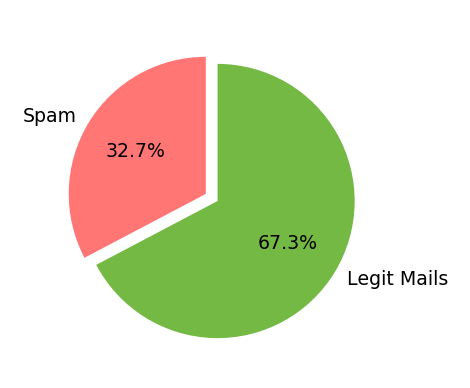

In [25]:
plt.figure(figsize=(2,2), dpi =227)
plt.pie(size, labels = category_name, textprops = {'fontsize':6}, startangle=90, autopct = '%1.1f%%',
        colors = custom_colors,explode=[0,0.1])
plt.show()

In [26]:
category_name = ['Spam', 'Legit Mails','Updates','Promotions']
size = [25, 83,93,21]
custom_colors = ['#ff7675','#74b944','#55efc4','#ffeaa7']
offsets = [0.05,0.05,0.05,0.05]

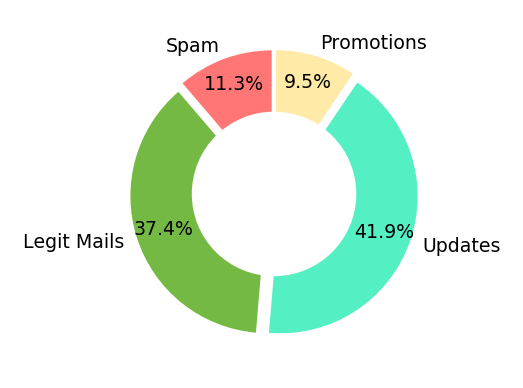

In [27]:
plt.figure(figsize=(2,2), dpi =227)
plt.pie(size, labels = category_name, textprops = {'fontsize':6}, startangle=90, autopct = '%1.1f%%',
        colors = custom_colors,pctdistance = 0.8,explode=offsets)



centre_circle = plt.Circle((0,0), radius = 0.6, fc= 'white')
plt.gca().add_artist(centre_circle)
plt.show()

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaleen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/shaleen/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/shaleen/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


True

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/shaleen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
msg = 'All work and no play HHAAA'
words = word_tokenize(msg.lower())

In [31]:
stop_words = set(stopwords.words('english'))
if 'hello' not in stop_words: print('Nope Not in there')

Nope Not in there


In [32]:
msg = 'All work and no play HHAAA! makes me very happish and sadening \
Pictures'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

['work', 'play', 'hhaaa', 'make', 'happish', 'saden', 'pictur']


In [33]:
data.at[2,'MESSAGE']

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [34]:
soup = BeautifulSoup(data.at[2,'MESSAGE'],'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [35]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [36]:
def clean_message(message, stop_words = set(stopwords.words('english')), stemmer = PorterStemmer(),):
    words = word_tokenize(message.lower())
    
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [37]:
def clean_message_without_html_tags(message, stop_words = set(stopwords.words('english')), stemmer = PorterStemmer(),):
    
    
    filtered_words = []
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    words = word_tokenize(cleaned_text.lower())
    for word in words:
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [38]:
clean_message_without_html_tags(data.at[2,'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

In [39]:
clean_message(data.at[2,'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'http',
 'legal',
 'notic',
 'http',
 'html',
 'head',
 'titl',
 'dare',
 'find',
 'better',
 'annuiti',
 'meta',
 'bodi',
 'font',
 'arial',
 'helvetica',
 'tabl',
 'center',
 'ffffff',
 'tr',
 'td',
 'img',
 'http',
 'dare',
 'br',
 'img',
 'http',
 'tri',
 'find',
 'better',
 'annuiti',
 'br',
 'img',
 'http',
 'tabl',
 'ffffff',
 'tr',
 'td',
 'img',
 'http',
 'img',
 'http',
 'guarante',
 'year',
 'year',
 'surrend',
 'charg',
 'agent',
 'commiss',
 'age',


In [40]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)
nested_list

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
Name: MESSAGE, dtype: object

In [41]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
# print(len(flat_list))

flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

390

In [45]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message_without_html_tags)

/Users/shaleen/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 31.7 s, sys: 235 ms, total: 31.9 s
Wall time: 32.5 s


In [43]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index
print(doc_ids_ham)

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)


# nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.loc[]

In [74]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam

DOC_ID
0       [dear, homeown, interest, rate, lowest, point,...
1       [attent, must, comput, user, packag, deal, nor...
2       [messag, mime, format, dare, tri, find, better...
3       [import, inform, new, domain, name, final, ava...
4       [bottom, line, give, away, cd, free, peopl, li...
5       [kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrk...
6       [p, color, navi, hello, chines, tradit, äúïëò,...
7       [secur, invest, wealth, without, risk, discov,...
8       [click, simpli, amateur, like, girl, next, doo...
9       [unlist, inform, messag, brought, complianc, c...
10      [dear, consum, increas, busi, sale, target, mi...
11      [tire, pay, big, buck, satellit, dont, low, bu...
12      [new, web, technolog, unlimit, web, ferenc, su...
13      [b, b, al, b, n, k, ni, b, b, jj, n, b, b, g, ...
14      [kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrk...
15      [immedi, help, need, fortun, compani, grow, tr...
16      [messag, mime, format, diversifi, underwrit, s...
17     

In [66]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()
spam_words.shape

(13284,)

In [75]:
spam_words.iloc[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

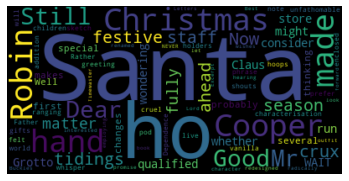

In [81]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [84]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [85]:
example_corpus


['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [87]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

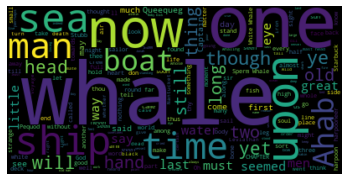

In [88]:
word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
es = [word for word in example_corpus]
es,

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

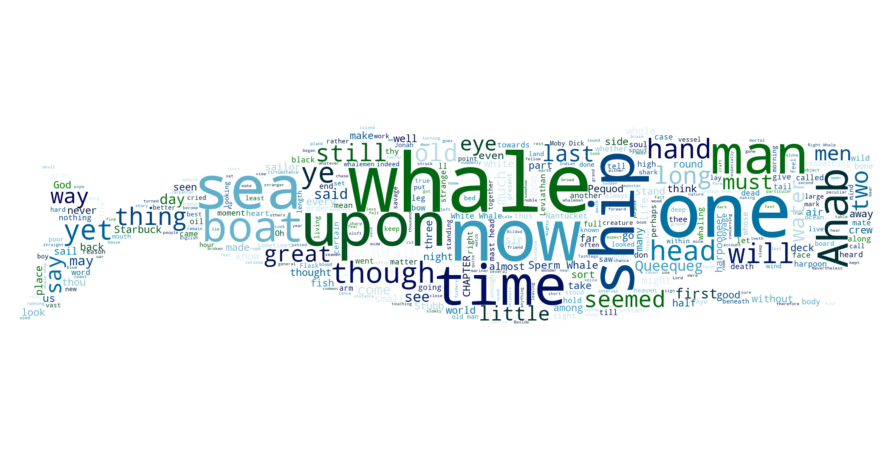

In [104]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode ='RGB', size = icon.size,color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [107]:
new_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

In [108]:
word_list2 = [''.join(word) for word in new_corpus]
novel_as_string2 = ' '.join(word_list)
novel_as_string2

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

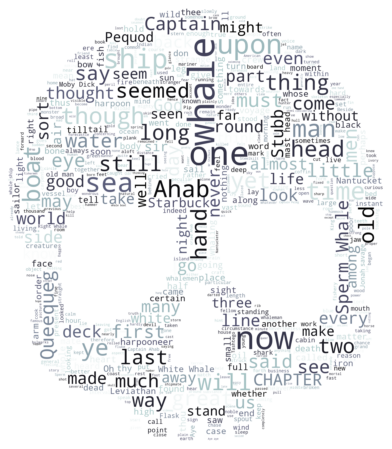

In [112]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode ='RGB', size = icon.size,color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=600,colormap='bone')
word_cloud.generate(novel_as_string2)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

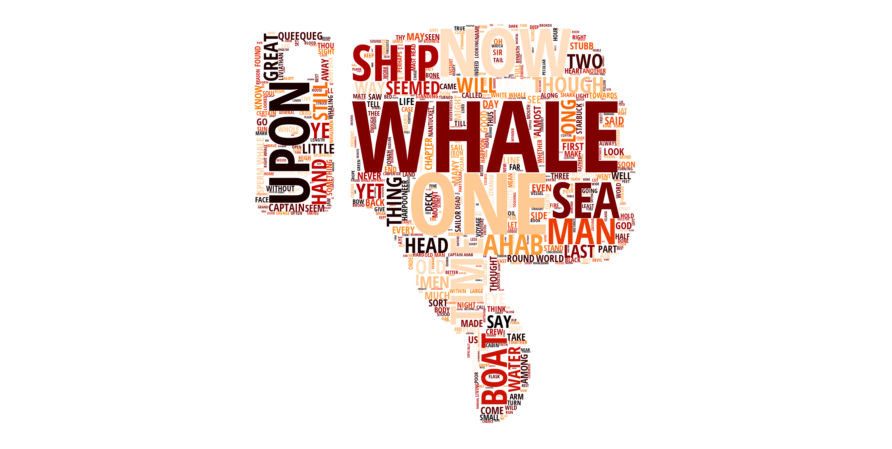

In [120]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode ='RGB', size = icon.size,color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)
spam_string = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white',max_font_size=300,
                       max_words=600,font_path=CUSTOM_FONT_FILE,colormap='gist_heat')
word_cloud.generate(novel_as_string2.upper())
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [121]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_without_html_tags)
flat_nested_list = [item for sublist in stemmed_nested_list for item in sublist]

/Users/shaleen/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [124]:
unique_words = pd.Series(flat_nested_list).value_counts()
unique_words.shape[0]


27305

In [143]:
frequent_words = unique_words[0:VOCAB_SIZE]
type(frequent_words.index.values)

numpy.ndarray

In [153]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values})
vocab.index.name = 'WORD_ID'
vocab

VOCAB_WORD
WORD_ID             
0               http
1                use
2               list
3              email
4                get
5               mail
6                one
7               free
8               time
9               work
10            messag
11              make
12              like
13             would
14             peopl
15               new
16            inform
17            receiv
18             pleas
19             click
20              busi
21           address
22              want
23                us
24              need
25             order
26             remov
27              also
28                go
29              year
...              ...
2470             bsd
2471         maxaman
2472       everywher
2473           shoot
2474          potent
2475         contest
2476         tobacco
2477          milter
2478           layer
2479            hook
2480           ratak
2481           dedic
2482          ximian
2483           scope
2484          flight
2485            elig
2486         quarter
2487      telecommun
2488        magnitud
2489          murjel
2490         subsequ
2491           navig
2492              rm
2493            bond
2494         pleasur
2495            raid
2496          bullet
2497     distributor
2498          burner
2499            zone

[2500 rows x 1 columns]

In [147]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)

In [166]:
for word in vocab.VOCAB_WORD:
    
    if word in ['machine','fun','learn','data','science','app','brewery']:
        print(word)
        print (True)

data
True
learn
True
fun
True
app
True


In [269]:
any(vocab.VOCAB_WORD == 'thu')

True

In [169]:
'machin' in set(vocab.VOCAB_WORD)

True

In [208]:
emails = data.MESSAGE.apply(clean_message_without_html_tags)
emails.value_counts

/Users/shaleen/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


AttributeError: 'Series' object has no attribute 'value_count'

In [207]:
clean_email = [len(sublist) for sublist in emails]
print(max(clean_email))

7671


In [213]:
np.argmax(clean_email)
emails[np.argmax(clean_email)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [216]:
data.at[np.argmax(clean_email),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

In [218]:
stemmed_nested_list.tolist()

[['dear',
  'homeown',
  'interest',
  'rate',
  'lowest',
  'point',
  'year',
  'help',
  'find',
  'best',
  'rate',
  'situat',
  'match',
  'need',
  'hundr',
  'lender',
  'home',
  'improv',
  'refin',
  'second',
  'mortgag',
  'home',
  'equiti',
  'loan',
  'even',
  'less',
  'perfect',
  'credit',
  'servic',
  'free',
  'home',
  'owner',
  'new',
  'home',
  'buyer',
  'without',
  'oblig',
  'fill',
  'quick',
  'simpl',
  'form',
  'futur',
  'plan',
  'today',
  'visit',
  'http',
  'unsubscrib',
  'pleas',
  'visit',
  'http'],
 ['attent',
  'must',
  'comput',
  'user',
  'packag',
  'deal',
  'norton',
  'systemwork',
  'softwar',
  'suit',
  'includ',
  'six',
  'ye',
  'util',
  'special',
  'low',
  'price',
  'softwar',
  'protect',
  'comput',
  'unwant',
  'hazard',
  'virus',
  'help',
  'secur',
  'privat',
  'valuabl',
  'inform',
  'allow',
  'transfer',
  'file',
  'send',
  'safe',
  'backup',
  'data',
  'quick',
  'easili',
  'improv',
  'pc',
  'perfo

In [234]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

0     \
0                                                  dear   
1                                                attent   
2                                                messag   
3                                                import   
4                                                bottom   
5     kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrky...   
6                                                     p   
7                                                 secur   
8                                                 click   
9                                                unlist   
10                                                 dear   
11                                                 tire   
12                                                  new   
13                                                    b   
14    kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrky...   
15                                               immedi   
16                                               messag   
17                                              thought   
18                                                 dear   
19                                                 kone   
20                                            copyright   
21                                                check   
22                                                  wet   
23                                               beauti   
24                                                 None   
25                                               messag   
26                                                chase   
27                                               spring   
28                                                 dear   
29                                                 slim   
...                                                 ...   
5766                                                sun   
5767                                             enough   
5768                                             messag   
5769                                             sunday   
5770                                                use   
5771                                               sort   
5772                                                 ad   
5773                                               date   
5774                                             sprach   
5775                                                 hi   
5776                                             messag   
5777                                                use   
5778                                              bryan   
5779                                               seem   
5780                                                wed   
5781                                                may   
5782                                                  e   
5783                                                wed   
5784                                                tri   
5785                                             friday   
5786                                               ryan   
5787                                                mon   
5788                                                jul   
5789                                                 hi   
5790                                                fri   
5791                                                one   
5792                                             damien   
5793                                                mon   
5794                                               upon   
5795                                                run   

                                                   1             2     \
0                                               homeown      interest   
1                                                  must        comput   
2                                                  mime        format   
3                                                inform           new   
4                          

In [274]:
X_train, X_test, Y_train , Y_test = train_test_split(word_columns_df, data.CATEGORY,random_state =42,test_size = 0.3)

In [276]:
X_train.index.name = X_test.index.name='DOC_ID'

In [277]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'subsequ', 'navig', 'rm', 'bond', 'pleasur', 'raid', 'bullet',
       'distributor', 'burner', 'zone'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [298]:
vocab

VOCAB_WORD
WORD_ID             
0               http
1                use
2               list
3              email
4                get
5               mail
6                one
7               free
8               time
9               work
10            messag
11              make
12              like
13             would
14             peopl
15               new
16            inform
17            receiv
18             pleas
19             click
20              busi
21           address
22              want
23                us
24              need
25             order
26             remov
27              also
28                go
29              year
...              ...
2470             bsd
2471         maxaman
2472       everywher
2473           shoot
2474          potent
2475         contest
2476         tobacco
2477          milter
2478           layer
2479            hook
2480           ratak
2481           dedic
2482          ximian
2483           scope
2484          flight
2485            elig
2486         quarter
2487      telecommun
2488        magnitud
2489          murjel
2490         subsequ
2491           navig
2492              rm
2493            bond
2494         pleasur
2495            raid
2496          bullet
2497     distributor
2498          burner
2499            zone

[2500 rows x 1 columns]

In [272]:
Y_train.shape

(1739,)

In [273]:
X_train.shape

(4057, 7671)

In [278]:
def make_sparse_matrix(df,indexed_words,labels):
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL':category , 'DOC_ID':doc_id, 'OCCURENCE':1, 'WORD_ID':word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
            

In [279]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, Y_train)

CPU times: user 3min 17s, sys: 1.98 s, total: 3min 19s
Wall time: 3min 30s


In [280]:
sparse_train_df.head()

DOC_ID  LABEL  OCCURENCE  WORD_ID
0    4844      0          1      395
1    4844      0          1      495
2    4844      0          1     2386
3    4844      0          1      496
4    4844      0          1       37

In [299]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [303]:
train_grouped.tail()

OCCURENCE
DOC_ID WORD_ID LABEL           
5795   1542    0              2
       1895    0              1
       1912    0              2
       2137    0              1
       2289    0              1

In [304]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        0      1          2
1       0        7      1          1
2       0       15      1          1
3       0       18      1          1
4       0       24      1          1

In [305]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d')

In [302]:
%%time

sparsed_test_df = make_sparse_matrix(X_test,word_index,Y_test)

CPU times: user 1min 26s, sys: 1.9 s, total: 1min 28s
Wall time: 1min 35s


In [295]:
test_grouped = sparsed_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()

In [297]:
np.savetxt(TEST_DATA_FILE, test_grouped,fmt='%d')